In [8]:
! unzip CMAPSSData.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

In [11]:
# define filepath to read data
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD002.txt', sep=r'\s+', header=None, names=col_names)
test = pd.read_csv('test_FD002.txt', sep=r'\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD002.txt', sep=r'\s+', header=None, names=['RUL'])

#shape and data
print(train.shape)
train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train_FD002.txt'

In [12]:
train.describe()

NameError: name 'train' is not defined

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = (result_frame["max_cycle"] - result_frame["time_cycles"])
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].tail(10)

,unit_nr,time_cycles,RUL
53749,260,307,9
53750,260,308,8
53751,260,309,7
53752,260,310,6
53753,260,311,5
53754,260,312,4
53755,260,313,3
53756,260,314,2
53757,260,315,1
53758,260,316,0


In [ ]:
#linear regression
#no feature engineering
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=130)
print(y_train_clipped.head(10))

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()

0    130
1    130
2    130
3    130
4    130
5    130
6    130
7    130
8    130
9    130
Name: RUL, dtype: int64


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)

    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [ ]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:23.110511440140176, R2:0.7169427855473895
test set RMSE:32.109826919230336, R2:0.6435046999739997


In [ ]:
#train val data split
from sklearn.model_selection import GroupShuffleSplit

# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)

def train_val_group_split(X, y, gss, groups, print_groups=True):

    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train_clipped, gss, train['unit_nr'])

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)
# set index because unit_nr begins at 1 instead of 0

In [ ]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

In [ ]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))

    if unit_nr:
        plt.plot('RUL', signal_name,
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 30 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

# specifically plotting s_2, I'm using this as an example throughout the rest of the analysis
#plot_signal(train, 's_7')

In [ ]:
useful_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
#useful_sensors = ['s_7', 's_8', 's_9',
       #'s_12', 's_16', 's_17', 's_20']
drop_sensors = [element for element in sensor_names if element not in useful_sensors]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

None


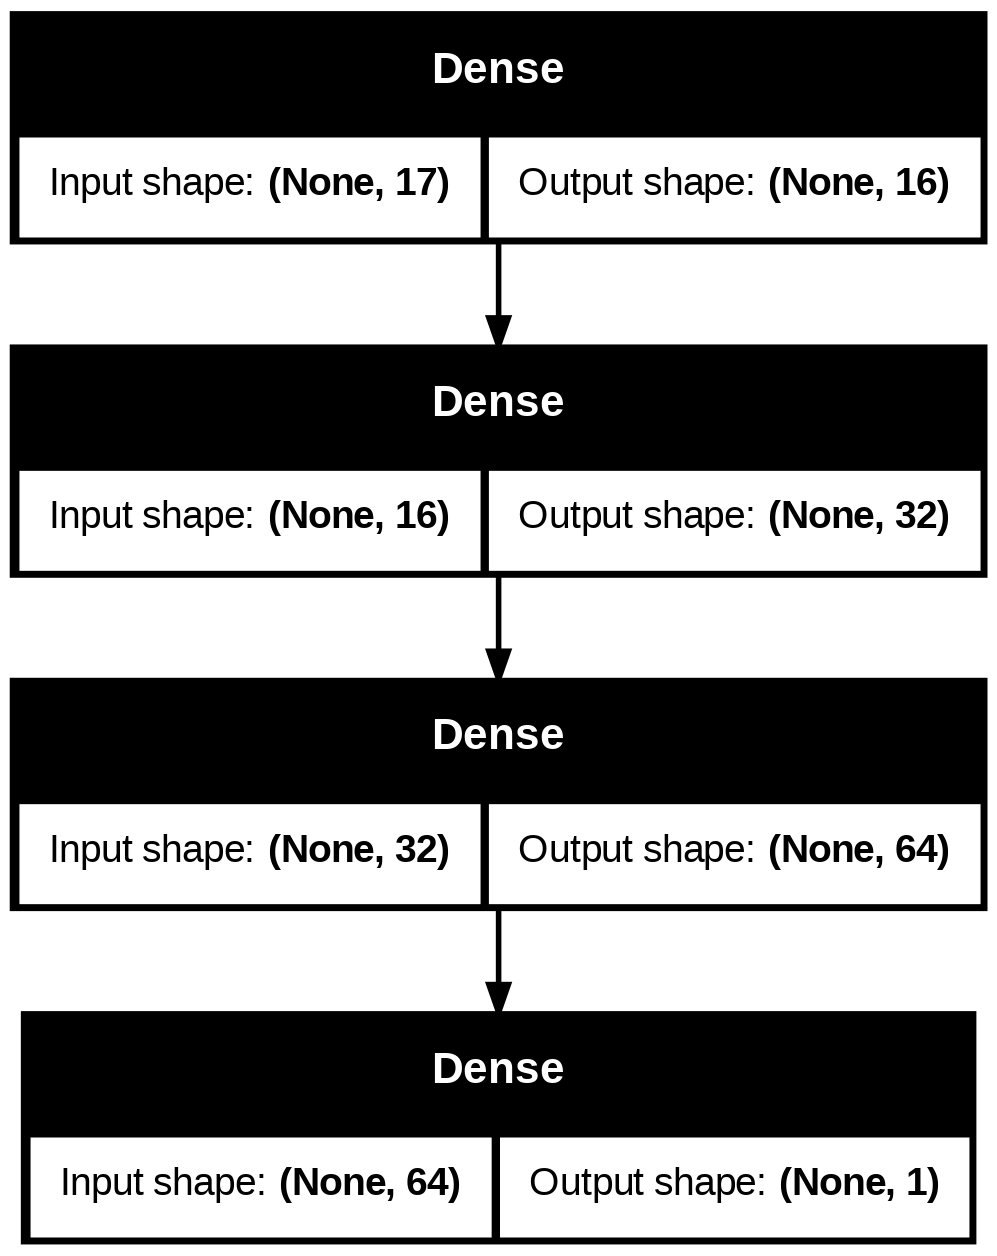

In [ ]:
#Vanilla neural network
#train_cols = setting_names+sensor_names
train_cols = setting_names+useful_sensors
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
keras.utils.plot_model(model, "dnn_model.png", show_shapes=True)

In [ ]:
before=time.time()
model_path = './vnn.keras'

epochs = 100

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs, batch_size=200,verbose=2,
                   callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
after=time.time()
traintime=after-before
print(traintime)

Epoch 1/100
218/218 - 5s - 21ms/step - loss: 2790.9121 - val_loss: 2031.8604
Epoch 2/100
218/218 - 1s - 2ms/step - loss: 2033.8596 - val_loss: 2017.7593
Epoch 3/100
218/218 - 1s - 3ms/step - loss: 2016.8752 - val_loss: 1998.5706
Epoch 4/100
218/218 - 1s - 5ms/step - loss: 1994.4705 - val_loss: 1982.8363
Epoch 5/100
218/218 - 1s - 4ms/step - loss: 1963.2294 - val_loss: 1938.9183
Epoch 6/100
218/218 - 2s - 8ms/step - loss: 1916.4905 - val_loss: 1902.0369
Epoch 7/100
218/218 - 2s - 8ms/step - loss: 1876.6400 - val_loss: 1864.1921
Epoch 8/100
218/218 - 1s - 5ms/step - loss: 1865.9584 - val_loss: 1868.9863
Epoch 9/100
218/218 - 1s - 2ms/step - loss: 1852.5958 - val_loss: 1852.7427
Epoch 10/100
218/218 - 1s - 3ms/step - loss: 1846.6730 - val_loss: 1883.4790
Epoch 11/100
218/218 - 2s - 7ms/step - loss: 1842.0504 - val_loss: 1839.6830
Epoch 12/100
218/218 - 1s - 5ms/step - loss: 1831.9757 - val_loss: 1848.9393
Epoch 13/100
218/218 - 1s - 4ms/step - loss: 1827.8417 - val_loss: 1815.0931
Epoch 1

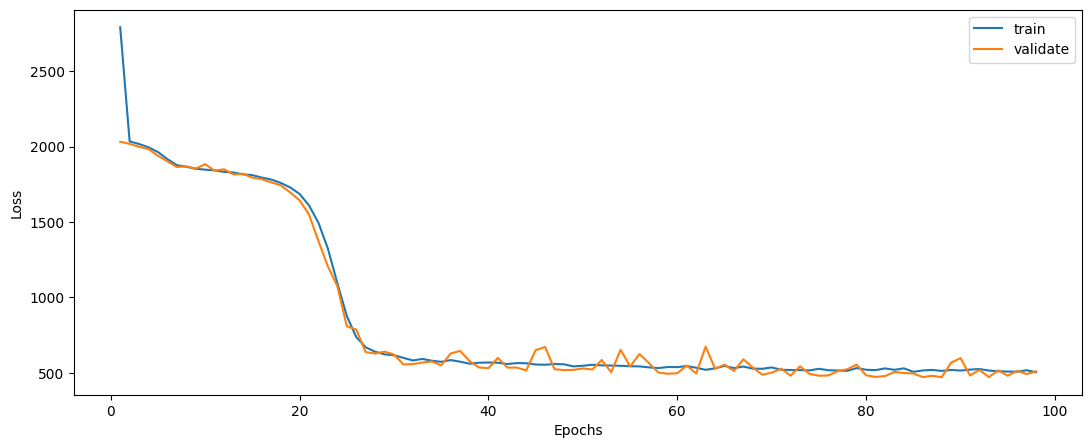

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_scaled[train_cols])
evaluate(y_test, y_hat_test)

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
train set RMSE:22.381460184868732, R2:0.7345199584960938
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
test set RMSE:30.809988644341736, R2:0.6717830896377563


In [ ]:
# 6 Settings conditions
settings_df = train[setting_names].copy()
settings_df['setting_1'] = settings_df['setting_1'].round()
settings_df['setting_2'] = settings_df['setting_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()


,,,0
setting_1,setting_2,setting_3,
0.0,0.00,100.0,8044
10.0,0.25,100.0,8096
20.0,0.70,100.0,8122
25.0,0.62,60.0,8002
35.0,0.84,100.0,8037
42.0,0.84,100.0,13458


In [ ]:
#plot sensors
#one sensor of one unit

def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))

    if unit_nr:
        plt.plot('RUL', signal_name,
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 15 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('RUL')
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)

    return df_op_cond

X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

In [ ]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

#for sensor in sensor_names:
    #plot_signal(X_train_condition_scaled, sensor)

<ipython-input-28-622265975d48>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.1674041  -1.59188977 -0.1674041  ...  0.54483874  1.96932442
  2.68156725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-28-622265975d48>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.59188977 -0.87964693  0.54483874 -0.1674041  -1.59188977 -0.1674041
  1.96932442 -0.87964693 -0.87964693  0.54483874 -0.1674041   0.54483874
 -0.1674041  -0.1674041  -0.87964693 -0.87964693 -1.59188977  0.54483874
 -0.1674041   1.25708158  0.54483874 -0.1674041   0.54483874  1.25708158
  0.54483874  1.25708158 -0.87964693 -0.1674041  -0.87964693 -0.1674041
  

In [ ]:
useful_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in useful_sensors]

In [ ]:

split_result = train_val_group_split(X_train_condition_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=False)
X_train_split_condition_scaled, y_train_clipped_split_condition_scaled = split_result[:2]
X_val_split_condition_scaled, y_val_clipped_split_condition_scaled = split_result[2:]

# we have to redefine our model as our inputs changed
input_dim = len(X_train_split_condition_scaled[useful_sensors].columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
before=time.time()
history = model.fit(X_train_split_condition_scaled[useful_sensors], y_train_clipped_split_condition_scaled,
                    validation_data=(X_val_split_condition_scaled[useful_sensors], y_val_clipped_split_condition_scaled),
                    epochs=epochs, batch_size=200,verbose=2,
                   callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
#plot_loss(history)
after=time.time()
print(after-before)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 - 3s - 14ms/step - loss: 4435.2603 - val_loss: 1062.8191
Epoch 2/100
218/218 - 1s - 4ms/step - loss: 906.6491 - val_loss: 654.6359
Epoch 3/100
218/218 - 1s - 2ms/step - loss: 621.7214 - val_loss: 510.9497
Epoch 4/100
218/218 - 1s - 4ms/step - loss: 516.9841 - val_loss: 471.9346
Epoch 5/100
218/218 - 1s - 6ms/step - loss: 483.5371 - val_loss: 451.3862
Epoch 6/100
218/218 - 2s - 7ms/step - loss: 467.7004 - val_loss: 448.1709
Epoch 7/100
218/218 - 2s - 8ms/step - loss: 458.2918 - val_loss: 444.8542
Epoch 8/100
218/218 - 2s - 11ms/step - loss: 451.4241 - val_loss: 446.9380
Epoch 9/100
218/218 - 1s - 4ms/step - loss: 446.2539 - val_loss: 437.8882
Epoch 10/100
218/218 - 0s - 2ms/step - loss: 442.1277 - val_loss: 432.2778
Epoch 11/100
218/218 - 1s - 3ms/step - loss: 439.0413 - val_loss: 430.5945
Epoch 12/100
218/218 - 1s - 3ms/step - loss: 437.0425 - val_loss: 433.3455
Epoch 13/100
218/218 - 1s - 3ms/step - loss: 434.5154 - val_loss: 433.1264
Epoch 14/100
218/218 - 1s - 3ms/step - los

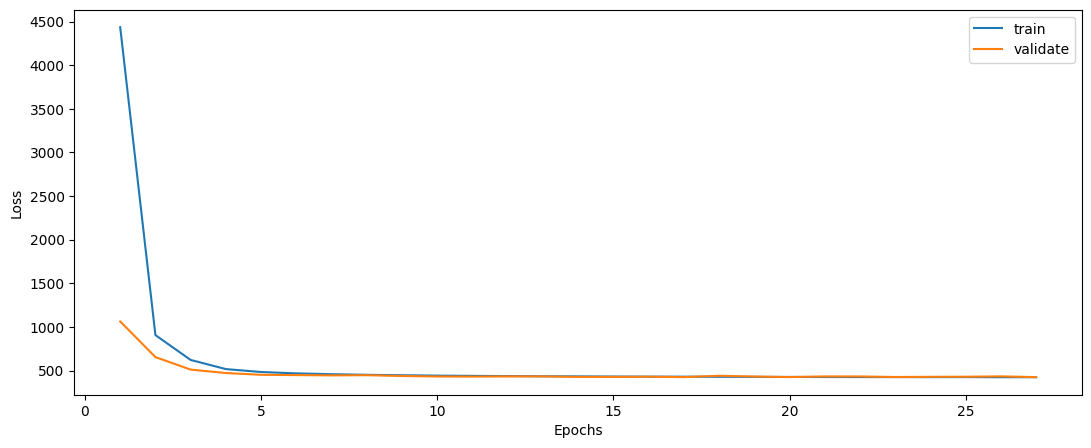

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
y_hat_train = model.predict(X_train_condition_scaled[useful_sensors])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled[useful_sensors])
evaluate(y_test, y_hat_test)

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
train set RMSE:20.571515676066333, R2:0.7757214903831482
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
test set RMSE:28.590304713743443, R2:0.7173718214035034


In [ ]:
#lstm

In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# pick the feature columns
# sensor_cols = ['s' + str(i) for i in range(1,22)]
# sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
# sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(X_train_condition_scaled[X_train_condition_scaled['unit_nr']==id], sequence_length, useful_sensors))
           for id in X_train_condition_scaled['unit_nr'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(40759, 50, 14)

In [ ]:
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(X_train_condition_scaled[X_train_condition_scaled['unit_nr']==id], sequence_length, ['RUL'])
             for id in X_train_condition_scaled['unit_nr'].unique()]

In [ ]:
label_gen
label_array = np.concatenate(list(label_gen)).astype(np.float32)
label_array.shape

(40759, 1)

In [ ]:
import keras
import keras.backend as K
from tensorflow.keras.layers import Activation # Changed import statement
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 100)             │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,251 (297.86 KB)

 Trainable params: 76,251 (297.86 KB)

 Non-trainable params: 0 (0.00 B)

None


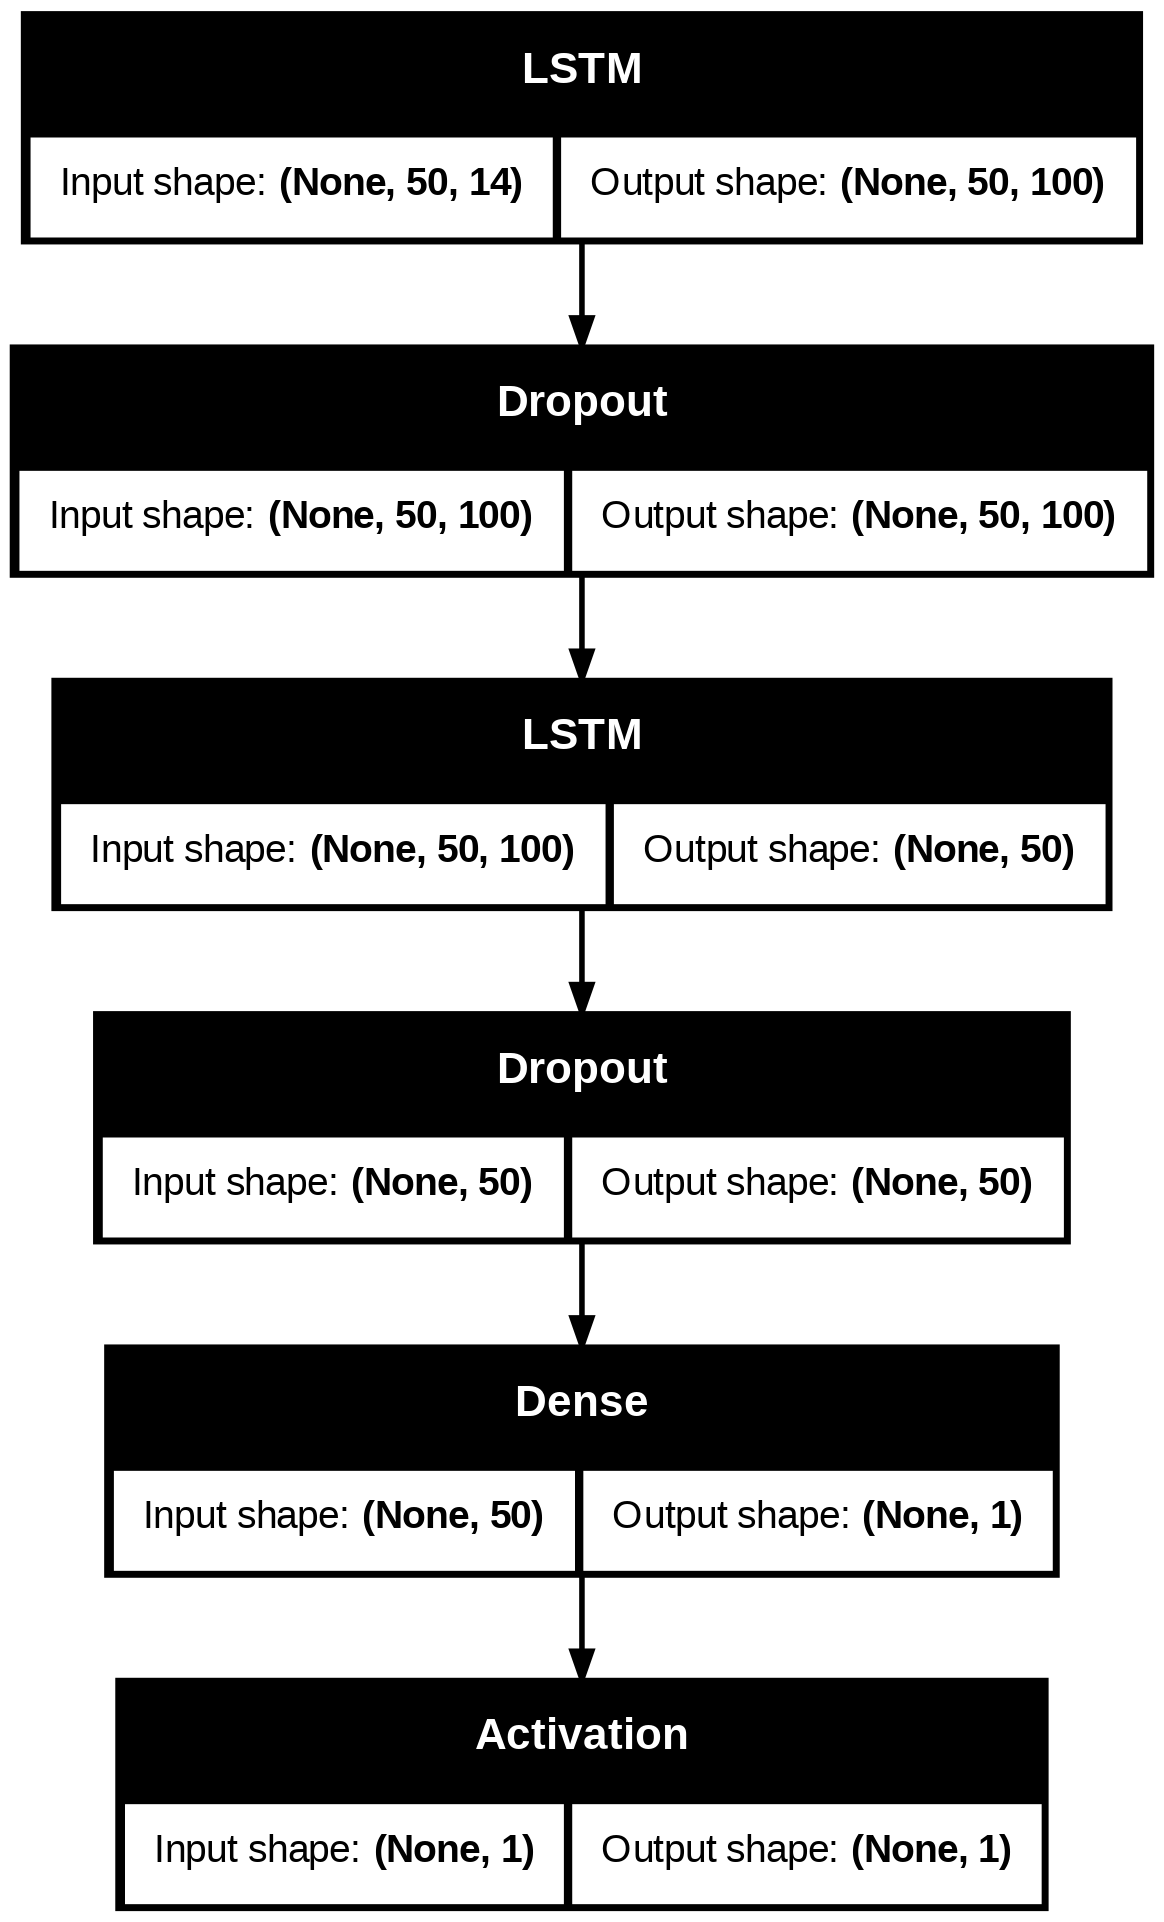

In [ ]:
model_path = './lstm.keras'

import tensorflow.keras.backend as K # Import the backend directly from tensorflow.keras

def r2_keras(y_true, y_pred):
    """Coefficient of Determination
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mean_squared_error',r2_keras])

print(model.summary())
keras.utils.plot_model(model, "dnn_model.png", show_shapes=True)

In [ ]:
print(seq_array.shape)
print(label_array.shape)

(40759, 50, 14)
(40759, 1)


In [ ]:
# Check for NaN values in the data
print(f'NaN in seq_array: {np.isnan(seq_array).sum()}')
print(f'NaN in label_array: {np.isnan(label_array).sum()}')

NaN in seq_array: 0
NaN in label_array: 0


In [ ]:
from tensorflow import keras
import time

before = time.time()

history = model.fit(
    seq_array,
    label_array,
    epochs=100,
    batch_size=200,
    validation_split=0.05,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
        keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0) # Changed 'model_path.keras' to model_path
    ]
)

after = time.time()
duration2 = after - before
print("Training time : ",duration2)

# list all data in history
print(history.history.keys())

Epoch 1/100
194/194 - 77s - 399ms/step - loss: 8081.6260 - mean_squared_error: 8081.6260 - r2_keras: -1.5464e+00 - val_loss: 11404.8105 - val_mean_squared_error: 11404.8105 - val_r2_keras: -1.8962e+00
Epoch 2/100
194/194 - 53s - 272ms/step - loss: 6779.5186 - mean_squared_error: 6779.5186 - r2_keras: -1.1318e+00 - val_loss: 9894.7393 - val_mean_squared_error: 9894.7393 - val_r2_keras: -1.3619e+00
Epoch 3/100
194/194 - 82s - 421ms/step - loss: 5646.6123 - mean_squared_error: 5646.6123 - r2_keras: -7.7395e-01 - val_loss: 8551.2012 - val_mean_squared_error: 8551.2012 - val_r2_keras: -9.8439e-01
Epoch 4/100
194/194 - 96s - 496ms/step - loss: 4671.9849 - mean_squared_error: 4671.9849 - r2_keras: -4.6736e-01 - val_loss: 7353.2705 - val_mean_squared_error: 7353.2705 - val_r2_keras: -6.0880e-01
Epoch 5/100
194/194 - 73s - 377ms/step - loss: 3834.4187 - mean_squared_error: 3834.4187 - r2_keras: -2.0290e-01 - val_loss: 6298.9756 - val_mean_squared_error: 6298.9756 - val_r2_keras: -3.3716e-01
Epo

In [ ]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(np.sqrt(scores[1])))
print('\nR^2: {}'.format(scores[2]))
#evaluate(seq_array, label_array)

204/204 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 74.2249 - mean_squared_error: 74.2249 - r2_keras: 0.9697

RMSE: 10.939086798957087

R^2: 0.9593887329101562


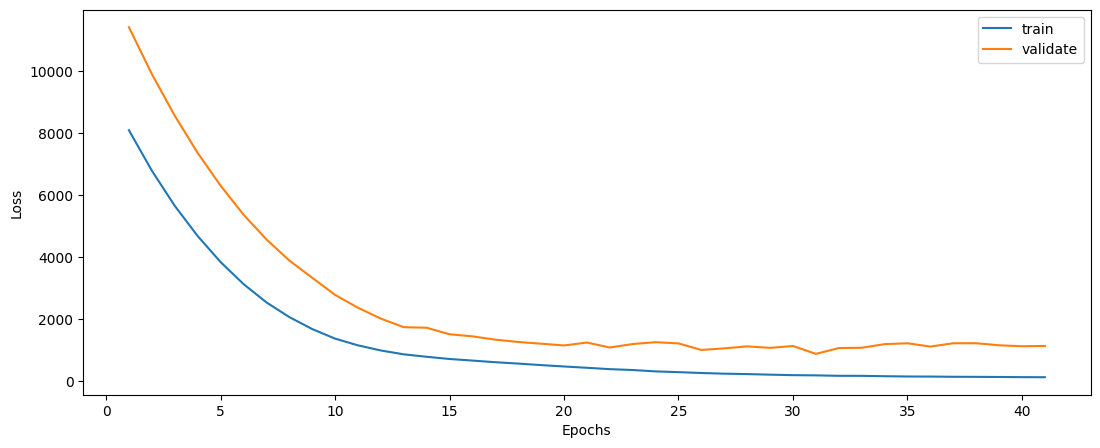

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)